In [28]:
# 1. 각각의 Client로컬 학습 모델의 Receptive Field를 계산한다.
import os
import sys
import pathlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import torch

def load_all_models(path):
    folder_path = path
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pth"):
                file_list.append(pathlib.Path(root) / file)
    # sorting file_list
    file_list.sort()
    # dirnames
    model_state_dict = {}
    for file in file_list:
        print("file_name : ", file)
        # get index from file name ex. "client_0_best_models" > "0", "test 1" > "1"
        if 'global' in file.parent.name:
            model_state_dict[-1] = torch.load(file) 
            print("file.parent.name: ", file.parent.name)
        else:
            index = int(file.parent.name.split('_')[1])
            model_state_dict[index] = torch.load(file)
            print("file.parent.name: ", file.parent.name, "index: ", index)
    return model_state_dict

model_state_dict = {}
model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/59831/global/model_round15_acc83.90_loss0.69.pth")
model_state_dict[-2] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/17751/global/model_round89_acc82.38_loss0.59.pth")
# model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/42705/client_3_best_models/model_round88_acc88.08_loss0.36.pth")
# model_state_dict.update(load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/55227")) # iid
model_state_dict.update(load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121")) # non-iid24211

file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_0_best_models/model_round49_acc79.41_loss0.90.pth
file.parent.name:  client_0_best_models index:  0
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_1_best_models/model_round86_acc90.98_loss0.27.pth
file.parent.name:  client_1_best_models index:  1
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_2_best_models/model_round30_acc94.40_loss0.22.pth
file.parent.name:  client_2_best_models index:  2
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_3_best_models/model_round53_acc90.52_loss0.28.pth
file.parent.name:  client_3_best_models index:  3
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_4_best_models/model_round60_acc95.83_loss0.24.pth
file.parent.name:  client_4_best_models index:  4
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/56121/client_5_best_models/model_

In [29]:
model_state_dict.keys()

dict_keys([-1, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import models
import utils
import datasets
import config
utils.set_seed(42)

In [31]:
args = config.init_args(server=True, ipykernel=True)
args.batch_size = 20
args.output_size = 224
datasetpartition_224 = datasets.PascalVocSegmentationPartition(args)
train_dataset_224, valid_dataset_224 = datasetpartition_224.load_partition(-1)
valid_loader_224 = DataLoader(valid_dataset_224, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader_224 = valid_loader_224
img_224, lab_224 = next(iter(test_loader_224))

args.excluded_heads []
malicious clients: []
dirichlet
1464 1449


In [32]:
args.output_size = 56
datasetpartition = datasets.PascalVocSegmentationPartition(args)
train_dataset, valid_dataset = datasetpartition.load_partition(-1)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader = valid_loader
img, lab = next(iter(test_loader))

malicious clients: []
dirichlet
1464 1449


In [33]:
network = models.get_network("segformer", 21, pretrained=True).cuda()
network2 = models.get_network("deeplabv3plus", 21, pretrained=True).cuda()

Loading pretrained model...


In [34]:
# # img_224 vs img plot
# %matplotlib inline
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(img_224[0].permute(1, 2, 0))
# ax[1].imshow(img[0].permute(1, 2, 0))


In [35]:
img.shape, lab.shape

(torch.Size([20, 3, 224, 224]), torch.Size([20, 56, 56]))

In [36]:
# 1) draw orginal image
# 2) draw predicted image with ground truth boundary for each client
# CUDA_LAUNCH_BLOCKING=1.

img = img.cuda()
# img_index = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
img_index = [0,4,7,9,11,16]
img = img[img_index]
lab = lab[img_index]
network = network.cuda()
network2 = network2.cuda()
preds = {}
for key in model_state_dict.keys():
    if key == -2:
        network2.load_state_dict(model_state_dict[key])
        out = network2(img).detach().cpu().numpy()
        # resize to (56, 56)
        # b x c x h x w > b x c x 56 x 56
        out = torch.tensor(out)
        out = torch.nn.functional.interpolate(out, size=(56, 56), mode='bilinear', align_corners=False)
        out = out.detach().cpu().numpy()
        preds[key] = out
    else:
        network.load_state_dict(model_state_dict[key])
        preds[key] = network(img).detach().cpu().numpy()
img = img.detach().cpu()

In [37]:
total_mIOUscores = []
def compute_mIoU(pred, target):
    ious = []
    for cls in range(21):
        pred_inds = pred == cls
        target_inds = target == cls
        print("pred_inds: ", pred_inds.shape, "target_inds: ", target_inds.shape)
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
    return np.nanmean(ious)

for i in model_state_dict.keys():
    mIOUscores = []
    temp_pred = preds[i]
    temp_pred = np.argmax(temp_pred, axis=1)
    for j in range(len(img_index)):
        mIOUscores.append(compute_mIoU(temp_pred[j], lab[j].numpy()))
    total_mIOUscores.append(mIOUscores)

pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds:  (56, 56)
pred_inds:  (56, 56) target_inds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


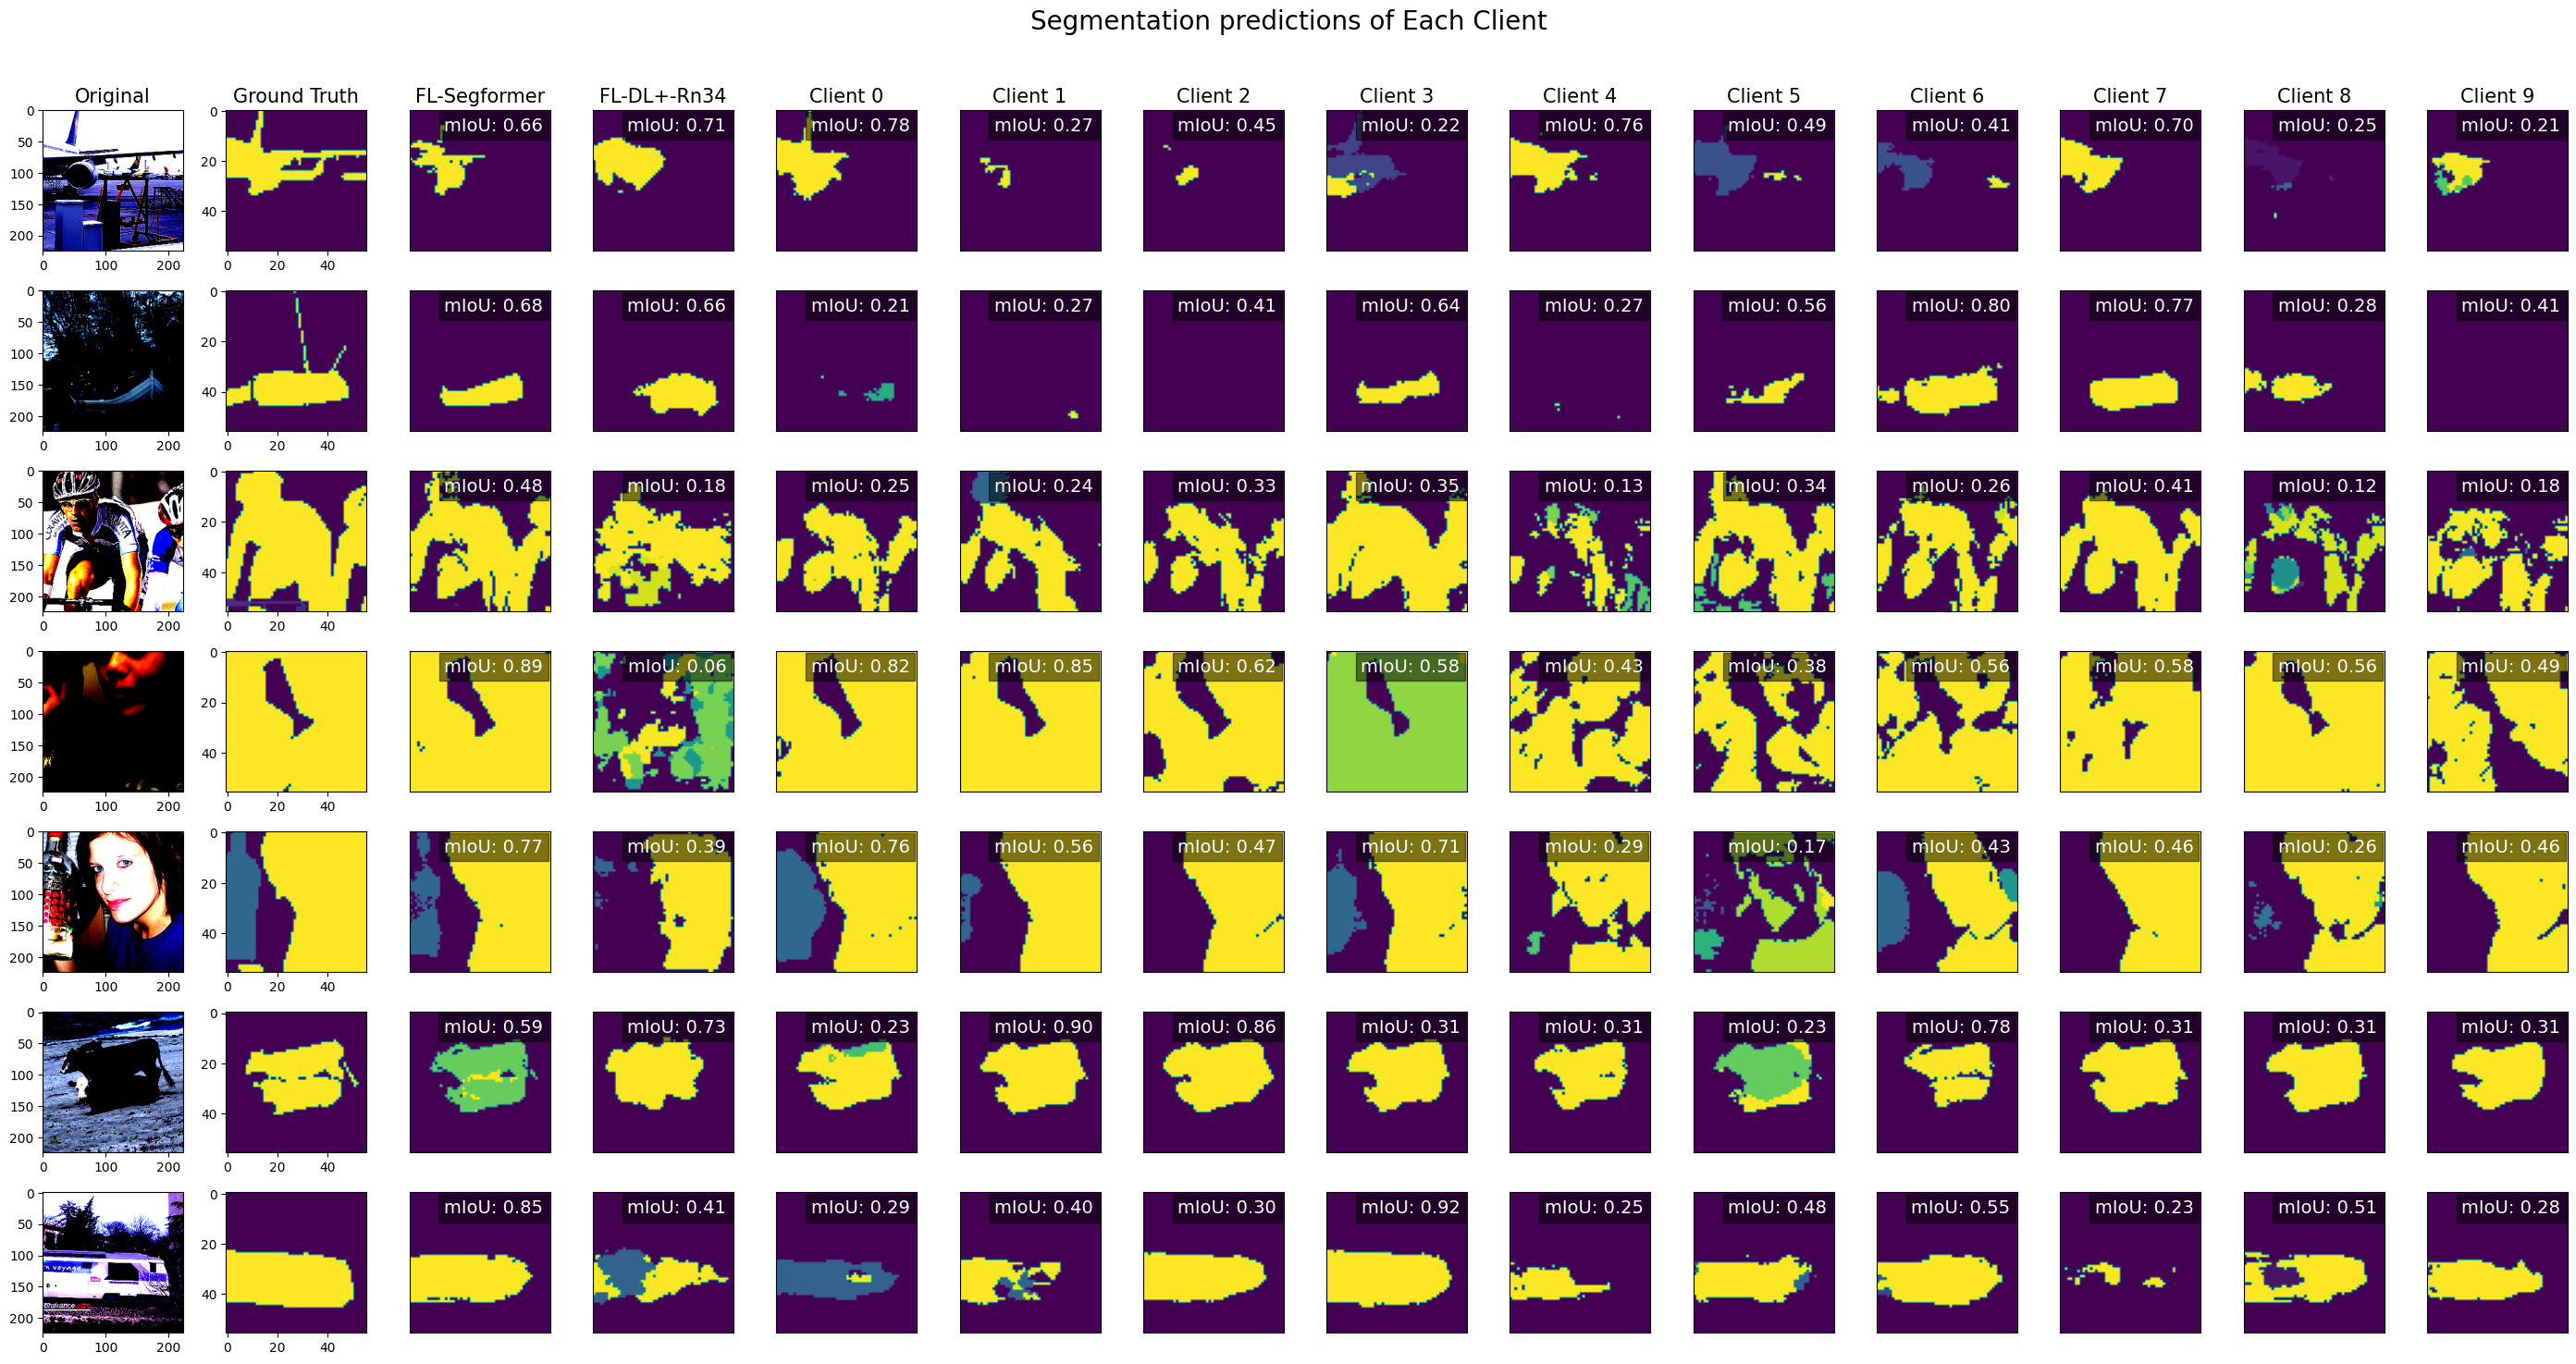

In [38]:
n_row = len(img)
n_col = len(model_state_dict.keys()) + 2 # 1 for original image, 1 for ground truth

pascal_voc_labels = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

def get_label_text(label):
    unique_labels = np.unique(label)
    num_instances = len(unique_labels)
    label_text = [pascal_voc_labels[l] for l in unique_labels if l != 0]
    label_text = ", ".join(label_text)
    return label_text

fig = plt.figure(figsize=(n_col*2, n_row*2))
for i in range(n_row):
    plt.subplot(n_row, n_col, i*n_col+1)
    if i == 0:
        plt.title("Original", fontsize=15)
    plt.imshow(img[i].permute(1, 2, 0))
    plt.subplot(n_row, n_col, i*n_col+2)
    if i == 0:
        plt.title("Ground Truth", fontsize=15)
    plt.imshow(lab[i])
    for j, key in enumerate(model_state_dict.keys()):
        plt.subplot(n_row, n_col, i*n_col+3+j)
        if i == 0:
            client_name  = f"Client {key}"
            client_name  = client_name if key != -2 else "FL-DL+-Rn34"
            client_name  = client_name if key != -1 else "FL-Segformer"
            plt.title(client_name, fontsize=15)
        plt.imshow(np.argmax(preds[key][i], axis=0))
        plt.xticks([])
        plt.yticks([])
        plt.text(0.95, 0.95, f"mIoU: {total_mIOUscores[j][i]:.2f}", color="white", fontsize=14, bbox=dict(facecolor='black', alpha=0.5)
                 , verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)

fig.tight_layout()
fig.suptitle("Segmentation predictions of Each Client", fontsize=20, y=1.05)
plt.savefig("figure4.png", dpi=300)
plt.show()


In [39]:
import numpy as np
import matplotlib.pyplot as plt

n_row = len(img)
n_col = len(model_state_dict.keys()) + 2  # 1 for original image, 1 for ground truth
pascal_voc_labels = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

def get_label_text(label):
    unique_labels = np.unique(label)
    num_instances = len(unique_labels)
    label_text = [pascal_voc_labels[l] for l in unique_labels if l != 0]
    label_text = ", ".join(label_text)
    return label_text

fig = plt.figure(figsize=(n_col*2, n_row*2))
fig.suptitle("Segmentation predictions of Each Client", fontsize=20)

for i in range(n_row):
    plt.subplot(n_row, n_col, i*n_col+1)
    if i == 0:
        plt.title("Original", fontsize=15)
    plt.imshow(img[i].permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    label_text = get_label_text(lab[i])
    print(label_text)
    plt.ylabel(get_label_text(lab[i]), fontsize=12, rotation=0, labelpad=40)  # y축 레이블 추가
    plt.subplot(n_row, n_col, i*n_col+2)
    if i == 0:
        plt.title("Ground Truth", fontsize=15)
    plt.imshow(lab[i])
    plt.text(0.95, 0.95, f"{label_text}", color="white", fontsize=14, bbox=dict(facecolor='black', alpha=0.5)
                 , verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)
    plt.xticks([])
    plt.yticks([])
    
    for j, key in enumerate(model_state_dict.keys()):
        plt.subplot(n_row, n_col, i*n_col+3+j)
        
        client_name  = f"Client {key}"
        client_name  = client_name if key != -2 else "FL-DL+-Rn34"
        client_name  = client_name if key != -1 else "FL-Segformer"
        plt.title(client_name, fontsize=15)
        plt.imshow(np.argmax(preds[key][i], axis=0))
        plt.xticks([])
        plt.yticks([])
        plt.text(0.95, 0.95, f"mIoU: {total_mIOUscores[j][i]:.2f}", color="white", fontsize=14, bbox=dict(facecolor='black', alpha=0.5)
                 , verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)


fig.tight_layout()
#figure title
plt.savefig("figure4.png", dpi=300)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


aeroplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


boat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bicycle, person
person


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bottle, person


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cow


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train
